# Introduction

In this notebook, we will implement word embeddings for job postings using [Word2vec](https://en.wikipedia.org/wiki/Word2vec). By implementing this, you will learn about embedding words in job postings such as job titles and skills. this will be useful when calculating similarity for job matching.

Table of contents

- [Word embeddings, word2vec](#Word-embeddings,-word2vec)
- [Job posting data](#Job-posting-data)
- [Data preprocessing](#Data-preprocessing)
- [Training](#Training)
- [Visualization](#Visualization)
- [Future work](#Future-work)
- [Reading](#Reading)


# Word embeddings, word2vec
Word2vec is a machine learning model used for learning vector representation of words, called "word embeddings".
Before starting implemenation, let's look at why we would want to learn work embeddings in the first place.

## Why learn word embeddings?
Natural language processing traditonally convert words to discrete symboles or ids. like `cat`, `dog` ->` 101`, `213`  
These encondings provide no useful information about relationships that may exist between individual symbols. representing words as unique, discrete ids furthermore leads to data sparsity, and requires many data. using vector representations can overcome some of these issues.

## Word2vec
Word2vec is a neural network model which allows you to vectorize words.
If you are interested in how to calculate vectors of words, read some of readings listed below.

<img src="assets/word2vec_diagrams.png" width="700">

Each word will be located as a point in hundreds-dimentional vectorspace (practically 300 - 500 dimentions). a well trained set of word vectors will place similar words close to eh other in that space. for instance, `dogs` and `cats` might cluster in one corner, while `war`, `conflict` and `strife` do in another.
Word2vec can learn many associations other than similarity. for instance, it can gauge relations between words of one language, and map them to another.

<img src="assets/word2vec_translation.png" width="700">

You can also do the following calculations with these vectors.

```
Rome - Italy + Japan = Tokyo
```
```
king - man + woman = queen
```

<img src="assets/countries_capitals.png" width="700">

## How are job word embeddings useful?
One of the reasons why we would want to learn "job word embeddings" is that it will be useful when calculating similar jobs with your current job title for job matching, which is difficult to be done by traditonal search-based system.  
We will see potential applications using the embeddings later in this notebook.

|Target job title|Similar job title|
|---|---|
|Web engineer| Server side eingeer, fullstack engineer, front-end engineer|
|Infra engineer| Devops engineer, System reliability engineer|
|Data scientist| Data analyist, Data engineer, Machine learning engineer|

# Job posting data
We need job titles and descriptions of them to learn what each title means.   

The dataset has 12130 postings with 13 fields: `job_title`, `summary`, `requirements`, `salary`, `location` etc. some explain job title well, other don't. we can decide which fields to use for learning.

Let's look at the raw data first.

In [1]:
import pandas as pd

job_postings = pd.read_csv('./data/job_postings.csv')
job_postings.head()

,_type,about_company,department,job_highlight,job_title,location,page_title,page_url,reason_for_hiring,requirements,salary,summary,tags
0,dict,ミッション「CLOSING THE DISTANCE」を軸に、人と人、様々な情報・サービスを...,NaN,【仕事の魅力】\n・900名規模のグローバルカンパニーで人事労務のキャリアを積むことができる...,人事労務,福岡県,【LINE】社員がやりがいをもって働ける環境を整える、人事労務,https://www.green-japan.com/job/60202,NaN,【必須の経験・スキル】\n・人事労務業務経験3年以上\n【歓迎する経験・スキル】\n・有期雇...,400万円〜,LINEおよび関連サービスの開発・クリエイティブ・運営・企画営業などあらゆる業務を行っていま...,#企画営業
1,dict,ミッション「CLOSING THE DISTANCE」を軸に、人と人、様々な情報・サービスを...,NaN,【仕事の魅力】\n・勢いのある広告サービスの利用規模拡大に携わることができる\n・ワークライ...,BtoBテレマーケティング担当(広告関連サービス/SV候補),福岡県,【LINE】LINE広告関連サービスのテレマーケティング担当(SV候補),https://www.green-japan.com/job/60664,事業拡大による増員,【必須の経験・スキル】\n・勢いのある広告サービスの利用規模拡大に携わることができる\n・ワ...,350万円〜,LINEおよび関連サービスの開発・クリエイティブ・運営・企画営業などあらゆる業務を行っていま...,#企画営業
2,dict,ミッション「CLOSING THE DISTANCE」を軸に、人と人、様々な情報・サービスを...,NaN,【仕事の魅力】\n・グローバルに展開しているゲームのマーケティングを経験できる\n・プラット...,マーケティング・プロモーション担当(LINEゲーム),福岡県,【LINE】ゲームタイトルのプロモーション企画をおこなうマーケティング担当,https://www.green-japan.com/job/60809,事業拡大による増員,【必須の経験・スキル】\n・プロモーション企画の提案・実施経験\n・広告のバナー制作・配信設...,350万円〜,LINEおよび関連サービスの開発・クリエイティブ・運営・企画営業などあらゆる業務を行っていま...,#企画営業
3,dict,＜会社概要＞\n今年で12期のまだまだ若くエネルギッシュな会社です。\n「いつも心にエンタテ...,テクノロジーソリューション事業部への配属となります。,【得られるスキル】 \n・カスタマーサクセスチームの立ち上げ経験 \n・グローバルで事業をグ...,【急成長イスラエルITベンチャーと働く】カスタマーサクセス職,東京都,急成長イスラエルITベンチャーと働く、カスタマーサクセスを大募集！,https://www.green-japan.com/job/54107,最先端ツールでWEB業界を革新中の弊社がさらなる成長を目指すため、\n一緒にカスタマーサクセ...,【必須スキル】 \n・BtoBセールス実務経験 \n・実務レベルの英語力 \n・Excel/...,300万円〜600万円,■Webマーケティング事業\n■テクノロジーソリューション事業\n\n 今回募集を...,#グローバル化\n#イスラエル\n#一気通貫
4,dict,＜会社概要＞\n今年で12期のまだまだ若くエネルギッシュな会社です。\n「いつも心にエンタテ...,テクノロジーソリューション事業部への配属となります。,【得られるスキル】 \n・潜在的な事業課題を導き出す高いヒアリング力 \n・チームの仕組み化...,【最先端ツールでWEB業界を変える】セールス職,東京都,急成長中！イスラエル・シリコンバレースタートアップと働く営業を募集中！,https://www.green-japan.com/job/54101,最先端ツールでWEB業界を革新中の弊社がさらなる成長を目指すため、\n一緒にセールスを行って...,【必須スキル】 \n・複数の関係者と協業できるコミュニケーション能力 \n・BtoBセールス...,300万円〜600万円,■Webマーケティング事業\n■テクノロジーソリューション事業\n\n ギャプライ...,#グローバル化\n#イスラエル\n#一気通貫


# Data preprocessing
TODO: add explanations

In [2]:
import re
import unicodedata

job_titles = job_postings['job_title']

def strip_brackets(text):
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'【.*】', '', text)
    text = re.sub(r'\[.*\]', '', text)
    text = re.sub(r'「.*」', '', text)
    text = re.sub(r'\(.*\)', '', text)
    text = re.sub(r'\<.*\>', '', text)
    text = re.sub(r'[※@◎].*$', '', text)
    return text

def normalize_job_title(title):
    title = strip_brackets(title)
    title = title.lower()
    return title

In [3]:
import MeCab
tagger = MeCab.Tagger("-U %m,未知語\\t -F %f[0],%f[6]\\t  -d  /usr/local/lib/mecab/dic/mecab-ipadic-neologd")

def extract_nouns(text): 
    words = []
    for row in tagger.parse(text).split('\t'):
        if row.strip() == 'EOS':
            continue
        t = row.split(',')[0]
        w = row.split(',')[1]
        if t == '名詞':
            words.append(w.strip().lower())
    return words

def convert_row(row):
    converted = []
    
    title_and_requirements  = [normalize_job_title(row['job_title'])] + extract_nouns(row['requirements'])
    converted.append(title_and_requirements)
    
    summary = extract_nouns(row['summary'])
    converted.append(summary)
    
    return converted

In [4]:
# convert data to inputs of Gensim's word2vec API
inputs = []
for _, p in job_postings.iterrows():
    inputs += convert_row(p)

In [5]:
print(' '.join(inputs[0]))

人事労務 必須 経験 スキル 人事 労務 業務 経験 3年 以上 歓迎 経験 スキル 有期雇用者 労務 相談 経験 社会保険労務士 有 資格者 歓迎 衛生管理者 有 資格者 歓迎 人物 像 バランス感覚 相手 立場 コミュニケーション 方 ポジティブ 問題意識 積極的 業務 方 困難 問題 発生 解決 まい進 方


# Training
TODO: add explanations

In [6]:
from gensim.models import word2vec

word2vec_model = word2vec.Word2Vec(inputs, size=100, min_count=5, window=10, sg=1) # train with CBOW algorithm 

word2vec_model.save('job_word_embeddings.model')

In [7]:
def similar_words(title):
    return word2vec_model.most_similar(normalize_job_title(title))

In [8]:
similar_words('Webエンジニア') # web engineer

[('サーバーサイドエンジニア', 0.894024133682251),
 ('webアプリケーションエンジニア', 0.8884859085083008),
 ('開発エンジニア', 0.8807929754257202),
 ('フルスタックエンジニア', 0.8669317364692688),
 ('rubyエンジニア', 0.8541393280029297),
 ('アプリケーションエンジニア', 0.8522626161575317),
 ('バックエンドエンジニア', 0.8449705839157104),
 ('サーバサイドエンジニア', 0.8391276597976685),
 ('web開発エンジニア', 0.838007926940918),
 ('phpエンジニア', 0.8357000946998596)]

In [9]:
similar_words('データエンジニア') # Data engineer

[('データ分析エンジニア', 0.9551975131034851),
 ('webアプリエンジニア', 0.9323302507400513),
 ('webシステム開発エンジニア', 0.9321702718734741),
 ('プロダクト開発エンジニア', 0.928466796875),
 ('システムエンジニア・プログラマ', 0.9268798828125),
 ('製品開発エンジニア', 0.9236086010932922),
 ('web・アプリエンジニア', 0.9205659031867981),
 ('ai開発エンジニア', 0.9167444109916687),
 ('リードエンジニア', 0.9135473370552063),
 ('webアプリケーション開発エンジニア', 0.9076213240623474)]

In [10]:
similar_words('UIデザイナー') # UIデザイナー

[('ui・uxデザイナー', 0.9300578236579895),
 ('ui/uxデザイナー', 0.9247347116470337),
 ('2dデザイナー', 0.909820556640625),
 ('エフェクトデザイナー', 0.8932684659957886),
 ('webデザイナー/コーダー', 0.8909474611282349),
 ('ux/uiデザイナー', 0.8906026482582092),
 ('webデザイナー・htmlコーダー', 0.8883530497550964),
 ('モーションデザイナー', 0.8801920413970947),
 ('クリエイティブディレクター', 0.878512978553772),
 ('webクリエイター', 0.8739585280418396)]

In [11]:
similar_words('Ruby')

[('php', 0.9214274883270264),
 ('perl', 0.8860471248626709),
 ('python', 0.8614218235015869),
 ('java', 0.8601683378219604),
 ('elixir', 0.8523225784301758),
 ('ruby on rails', 0.8406773805618286),
 ('node.js', 0.8406071662902832),
 ('言語', 0.8316036462783813),
 ('clojure', 0.8305398225784302),
 ('django', 0.829883873462677)]

In [12]:
similar_words('photoshop')

[('illustrator', 0.9814313054084778),
 ('fireworks', 0.9066299796104431),
 ('dreamweaver', 0.866407036781311),
 ('indesign', 0.8537789583206177),
 ('webデザイナー/コーダー', 0.847933292388916),
 ('sai', 0.8440274000167847),
 ('webデザイナー・htmlコーダー', 0.8425352573394775),
 ('clip studio', 0.8390226364135742),
 ('adobe photoshop', 0.8356441259384155),
 ('グラフィックソフト', 0.8333144783973694)]

In [13]:
similar_words('agile')

[('スクラム', 0.7797746658325195),
 ('ウォーターフォール', 0.7295132875442505),
 ('xp', 0.7062543630599976),
 ('テスト駆動開発', 0.6989679336547852),
 ('tdd', 0.6945051550865173),
 ('チケット駆動開発', 0.6927424669265747),
 ('開発プロセス', 0.6890267133712769),
 ('ペアプロ', 0.6875610947608948),
 ('heroku', 0.6765446662902832),
 ('water fowl', 0.6718463897705078)]

# Visualization
TODO: add explanations

In [14]:
import matplotlib.pyplot as plt 
from matplotlib.font_manager import FontProperties
from sklearn.manifold import TSNE
import numpy as np

fp = FontProperties(fname='/System/Library/Fonts/Hiragino Sans GB W3.ttc', size=14)

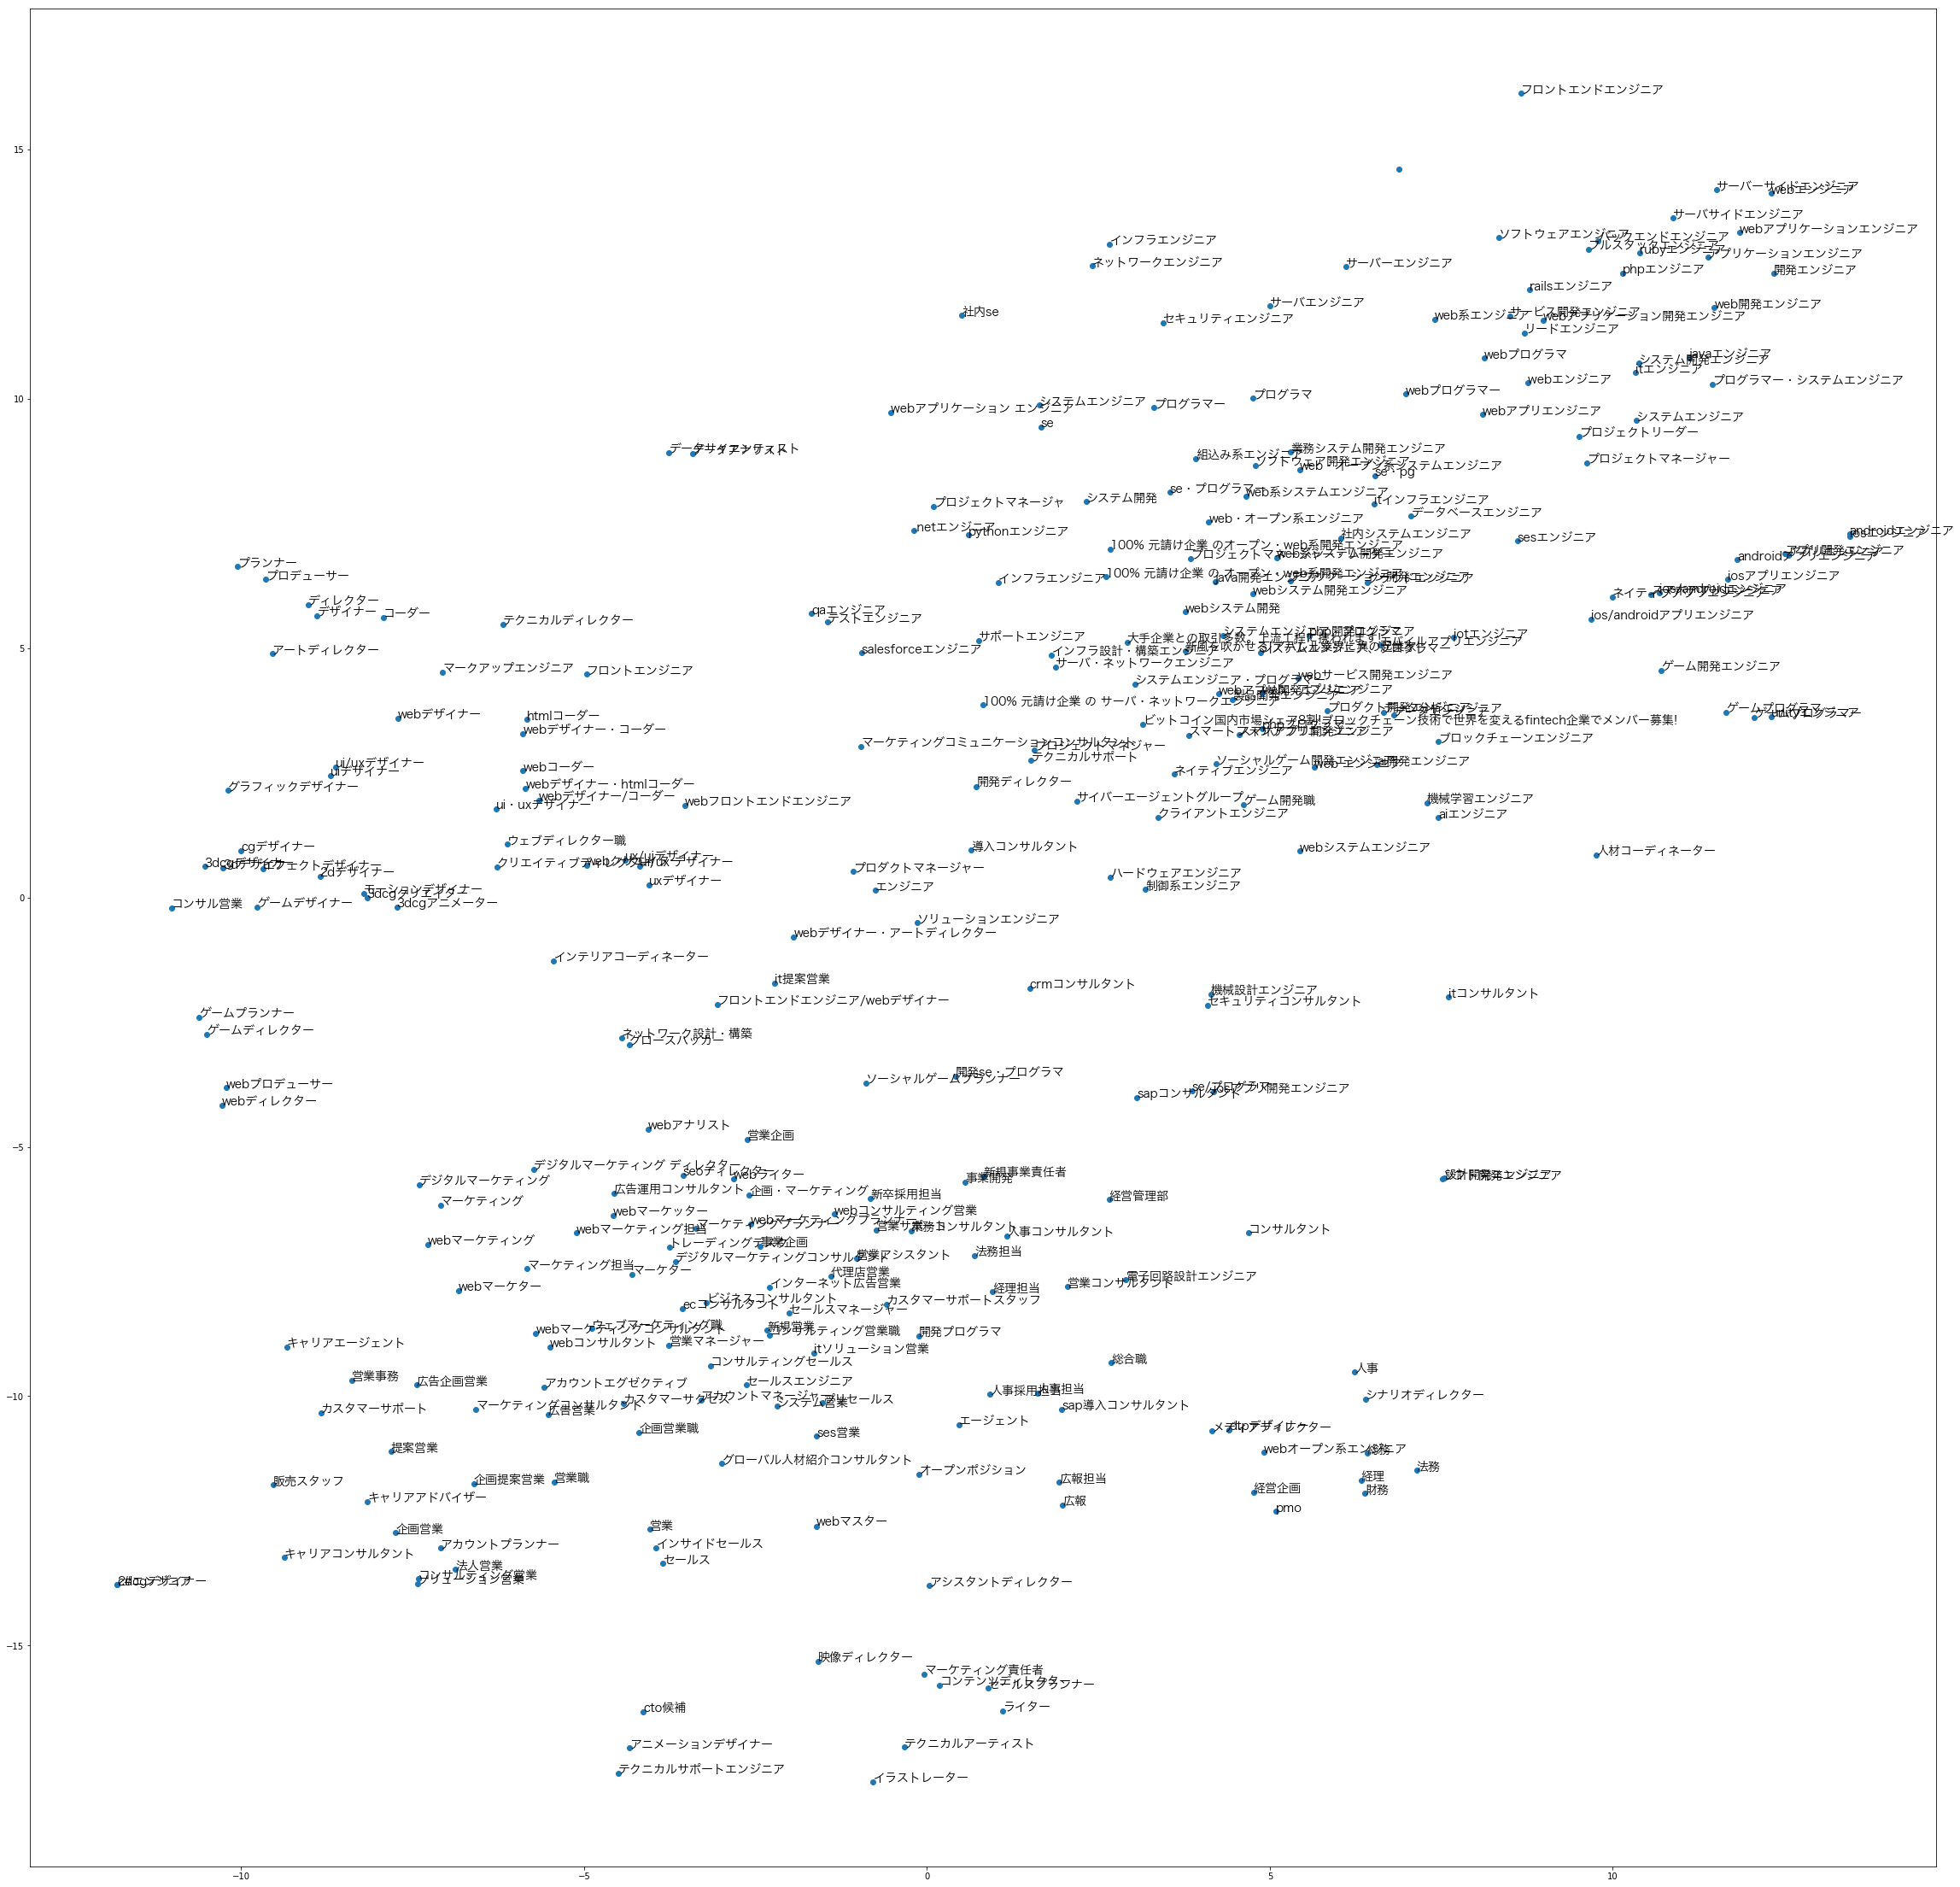

In [15]:
popular_job_titles = job_postings['job_title'].map(normalize_job_title).value_counts()[0:1000].keys()
emb_tuple = tuple([word2vec_model[t] for t in popular_job_titles if t in word2vec_model] )
X = np.vstack(emb_tuple)

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
model.fit_transform(X) 

#matplotlibでt-SNEの図を描く
plt.figure(figsize=(40,40))#図のサイズ
plt.scatter(model.embedding_[:, 0], model.embedding_[:, 1])

for label, x, y in zip(popular_job_titles, model.embedding_[:, 0], model.embedding_[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontproperties=fp)
    
plt.show()

# Future work
TODO: add potential applications

# Reading
Here are some resources which you can learn more about word2vec after workshop.
- [Gensim documentation](https://radimrehurek.com/gensim/models/word2vec.html)
- [Gensim word2vec tutorial](https://rare-technologies.com/word2vec-tutorial/)
- [Tensorflow tutorial](https://www.tensorflow.org/tutorials/word2vec)
- [Udacity material](https://github.com/udacity/deep-learning/blob/master/embeddings/Skip-Gram_word2vec.ipynb)
- [Conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)